# ERA5 Climate Gridded Data <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **[Sign up to the DEA Sandbox](https://app.sandbox.dea.ga.gov.au/)** to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` & `NCI` environments
* **Products used:** 
[ERA5](https://registry.opendata.aws/ecmwf-era5/) (*this dataset is external to the Digital Earth Australia platform*)

## Background

This notebook demonstrates how to download and use the European Centre for Medium Range Weather Forecasts (ECMWF) global climate reanalysis product called ERA5 from the [AWS Public Dataset Program](https://registry.opendata.aws/ecmwf-era5/). 

This 5th generation operational service utilizes the best available observation data from satellites and in-situ stations, which are assimilated and processed using ECMWF's Integrated Forecast System. 
The dataset provides essential atmospheric meteorological parameters such as air temperature, pressure and wind at different altitudes, along with surface parameters like rainfall, and sea parameters like sea-surface temperature and wave height. 
The spatial resolution of the data is 0.25 degrees (latitude and longitude) which equates to about 31 km. 
Data is available from 1979 to present and is updated operationally.

For offical information on this dataset, see [ERA5 data documentation from ECMWF](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation).

The ERA5 data in AWS include 18 surface or single level variables as described [here](https://github.com/planet-os/notebooks/blob/master/aws/era5-pds.md).
This dataset is nominally updated monthly however a delay of a few months has been observed.


## Description

This notebook demonstrates retrieval of ERA5 data using the DEA `load_era5()` wrapper function.

Available variables and names for query are:

| Catagory | Variable | Name for query |
|:--- |:--- |:--- |
| Precipitation | Total precipitation | precipitation_amount_1hour_Accumulation 
| Wind | 10 metre U wind component | eastward_wind_at_10_metres 
| | 10 metre V wind component | northward_wind_at_10_metres
| | 100 metre U wind component | eastward_wind_at_100_metres
| | 100 metre V wind component | northward_wind_at_100_metres
| Temperature | 2 metre temperature | air_temperature_at_2_metres
| | 2 metres maximum temperature since previous post-processing | air_temperature_at_2_metres_1hour_Maximum
| | 2 metres minimum temperature since previous post-processing | air_temperature_at_2_metres_1hour_Minimum
| | 2 metre dew point temperature | dew_point_temperature_at_2_metres
| | Sea surface temperature | sea_surface_temperature
| Air Pressure | Mean sea level pressure | air_pressure_at_mean_sea_level
| | Surface pressure | surface_air_pressure
| Wave | Mean wave period | sea_surface_wave_mean_period
| | Mean direction of waves | sea_surface_wave_from_direction
| | Significant height of combined wind waves and swell | significant_height_of_wind_and_swell_waves
| Snow | Snow density | snow_density
| | Snow depth | lwe_thickness_of_surface_snow_amount
| Solar radiation | Surface solar radiation downwards | integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation


Examples for the following parameters are covered:
1. Daily total precipitation
2. Daily minimum and maximum air temperature at 2 metres height
3. Hourly wind speed at 10 metres height
4. Monthly maximum air temperature at 2 metres height for the continent

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

> ***Note:*** This notebook will download climate data into your environment under the folder `era5`, depending on the number of variables and time-range you choose, this can result in a lot of data so be wary of exceeding the storage limits of the Sandbox (10 gb).

### Load packages

Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import datacube

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.climate import load_era5
from dea_tools.plotting import display_map


### Analysis parameters

Define location and time period of interest.
The time period is chosen to be no more than a few months to limit ERA5 data download.

* `lat` & `lon`: The latitude and longitude range for the area of interest.
* `buffer`:  The buffer to load around the central coordinates
* `time`: The time range you wish to extract data for


In [2]:
# Lake Victoria, NSW
lat, lon = -33.98, 141.27

# Set the buffer to load around the central coordinates
buffer = 0.1

# Define the time window
time = ('2019-01-01', '2019-01-31')

Visualise the location of interest

In [3]:
# Compute the bounding box for the study area
lat = (lat - buffer, lat + buffer)
lon = (lon - buffer, lon + buffer)

In [4]:
display_map(x=lon, y=lat, margin=-0.2)

## Daily total precipitation

Total precipitation is the accumulated liquid and frozen water, comprising rain and snow, that falls to the Earth's surface.
It does not include fog, dew or the precipitation that evaporates in the atmosphere before it lands at the surface of the Earth. 
The units of this parameter are depth in metres of water equivalent. It is the depth the water would have if it were spread evenly over the grid box. 
Care should be taken when comparing model parameters with observations, because observations are often local to a particular point in space and time, rather than representing averages over a model grid box.

In this example, total precipitation is aggregated at daily intervals.

Optional parameters used to load data:

* `reduce_func`: function to aggregate input hourly data, set to np.sum to calculate total precipitation.
* `resample`: temporal resampling frequency, '1D' (as default) for daily aggregation.
* `grid`: output gridding, 'nearest' (as default) for output spatial grid to be snapped to the nearest input grid points.

In [5]:
var = 'precipitation_amount_1hour_Accumulation'

precip = load_era5(var,
                   lat,
                   lon,
                   time,
                   reduce_func=np.sum,
                   resample='1D',
                   grid='nearest')

In [6]:
# Convert to Millimeters (mm), keeping other attributes
attrs = precip[var].attrs
attrs['units'] = 'mm'
precip = precip * 1000
precip[var].attrs = attrs

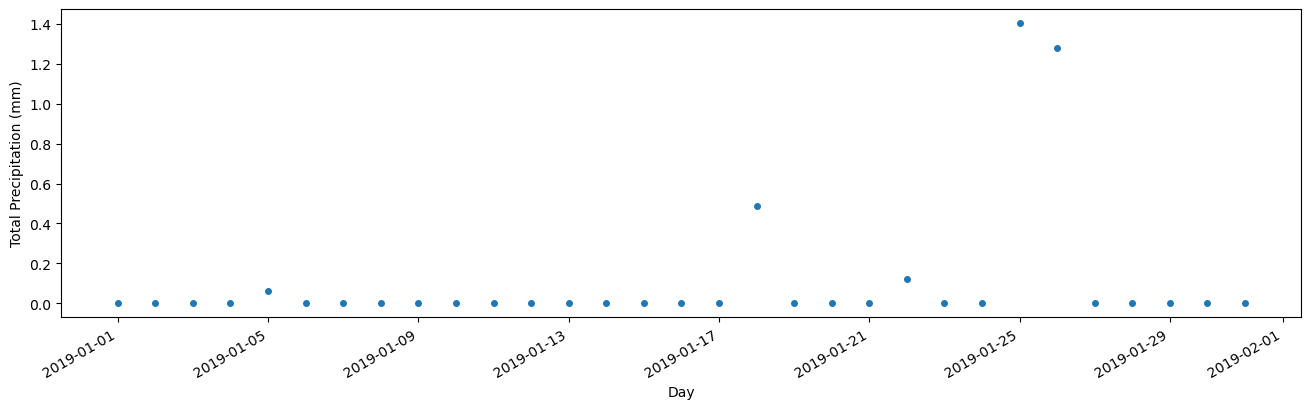

In [7]:
# Plot daily total precipitation for this area
precip[var].sum(['lat', 'lon']).plot(figsize=(16, 4),
                                     marker='o',
                                     markersize=4,
                                     linewidth=0)
plt.xlabel('Day')
plt.ylabel('%s (%s)' % ('Total Precipitation', precip[var].attrs['units']));

## Daily minimum and maximum air temperature at 2 metres height

Air temperature estimate is provided in kelvin (K) and can be converted to degrees Celsius (°C) by subtracting 273.15.

In this example, highest and lowerest daily temperatures are extracted.

Optional parameters used to load data:

* `reduce_func`: function to aggregate input hourly data, set to np.max and np.min to calculate maximum and minimum temperature.
* `resample`: temporal resampling frequency, '1D' (as default) for daily aggregation.
* `grid`: output gridding, 'nearest' (as default) for output spatial grid to be snapped to the nearest input grid points.

In [8]:
temp_var = 'air_temperature_at_2_metres'

temp_max = load_era5(temp_var,
                     lat,
                     lon,
                     time,
                     reduce_func=np.max,
                     resample='1D',
                     grid='nearest')

temp_min = load_era5(temp_var,
                     lat,
                     lon,
                     time,
                     reduce_func=np.min,
                     resample='1D',
                     grid='nearest')

In [9]:
# Convert to Celsius, keeping other attributes
attrs = temp_max.attrs
attrs['units'] = 'C'
temp_max, temp_min = temp_max - 273.15, temp_min - 273.15
temp_max[temp_var].attrs = attrs
temp_min[temp_var].attrs = attrs

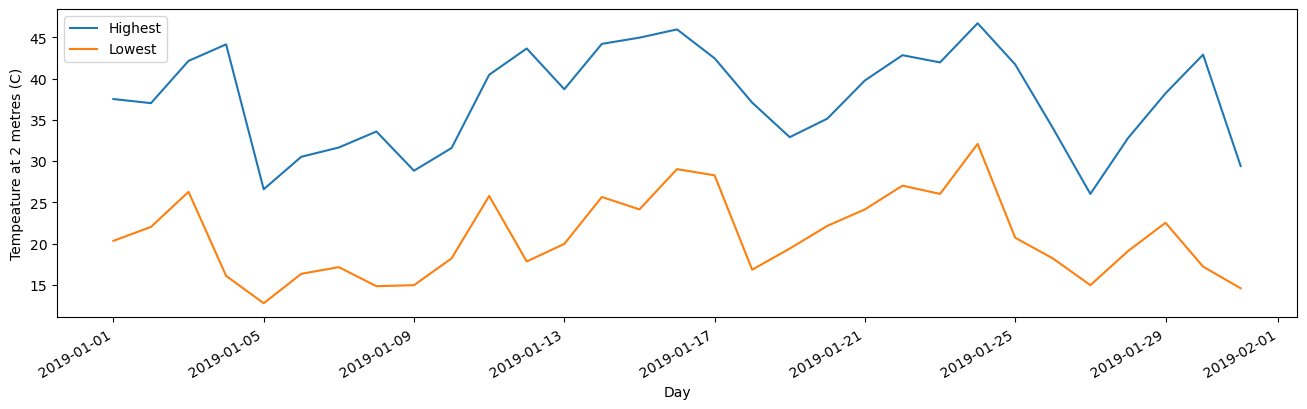

In [10]:
# Plot mean temperatures for this area
temp_max[temp_var].mean(['lat', 'lon']).plot(figsize=(16, 4), label='Highest')
temp_min[temp_var].mean(['lat', 'lon']).plot(label='Lowest')
plt.legend()
plt.xlabel('Day')
plt.ylabel('%s (%s)' %
           ('Tempeature at 2 metres', temp_max[temp_var].attrs['units']));

## Maximum hourly wind speed at 10 metres height

Wind causes changes in surface characteristic of some land cover types, e.g. surface roughness of water. 
Increased surface roughness leads to an increase in measured radar backscatter.
Although typically stronger than wind at surface, wind at 10 metres height may be used to flag windy conditions.

In ERA5, horizontal wind estimate is provided in metres per second and is represented by an eastward component and a northward component. 
A negative sign indicates air moving in the opposite direction, e.g. towards the west for the eastward component.
The two components can be combined to give the speed and direction of the horizontal wind.

Wind speed is highly variable throughout a day, so sampling is kept at hourly.

Optional parameters used to load data:

* `resample`: temporal resampling frequency, '1h' so that output data is at same frequency as input.
* `grid`: output gridding, 'nearest' (as default) for output spatial grid to be snapped to the nearest input grid points.

In [11]:
east = 'eastward_wind_at_10_metres'
north = 'northward_wind_at_10_metres'

wind_east = load_era5(east, lat, lon, time, resample='1h', grid='nearest')
wind_north = load_era5(north, lat, lon, time, resample='1h', grid='nearest')

### Combine the two wind components to get wind speed

Magnitude of the wind speed is calculated from U and V components as $sqrt(U^2 + V^2)$.

In [12]:
wind = (wind_east[east]**2 + wind_north[north]**2)**0.5
wind.attrs['units'] = wind_east[east].attrs['units']

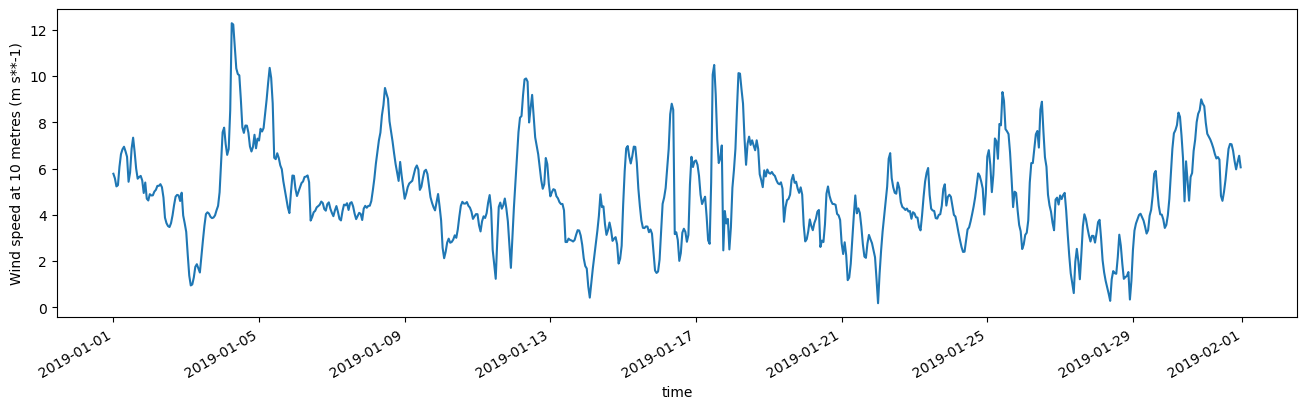

In [13]:
# Plot mean wind speed for this area
wind.mean(['lat', 'lon']).plot(figsize=(16, 4))
plt.ylabel('%s (%s)' % ('Wind speed at 10 metres', wind.attrs['units']));

## Monthly maximum air temperature at 2 metres height

In this example, maximum air temperature at 2 metres height is retrieved monthly for all of Australia.

Latitude and Longitude ranges are set to cover the continent.
Time range is to January for 2019.

Optional parameters used to load data:

* `reduce_func`: function to aggregate input hourly data, set to `np.max` to calculate mean temperature.
* `resample`: temporal resampling frequency, '1M' for monthly aggregation. This is the maximum aggregation period that will work for this function.

In [14]:
temp_var = 'air_temperature_at_2_metres'

temp_max_month = load_era5(temp_var, (-44, -8), (112, 156),
                           time,
                           reduce_func=np.max,
                           resample='1M')

# Convert to Celsius, keeping other attributes
attrs = temp_max_month.attrs
attrs['units'] = 'C'
temp_max_month = temp_max_month - 273.15
temp_max_month[temp_var].attrs = attrs

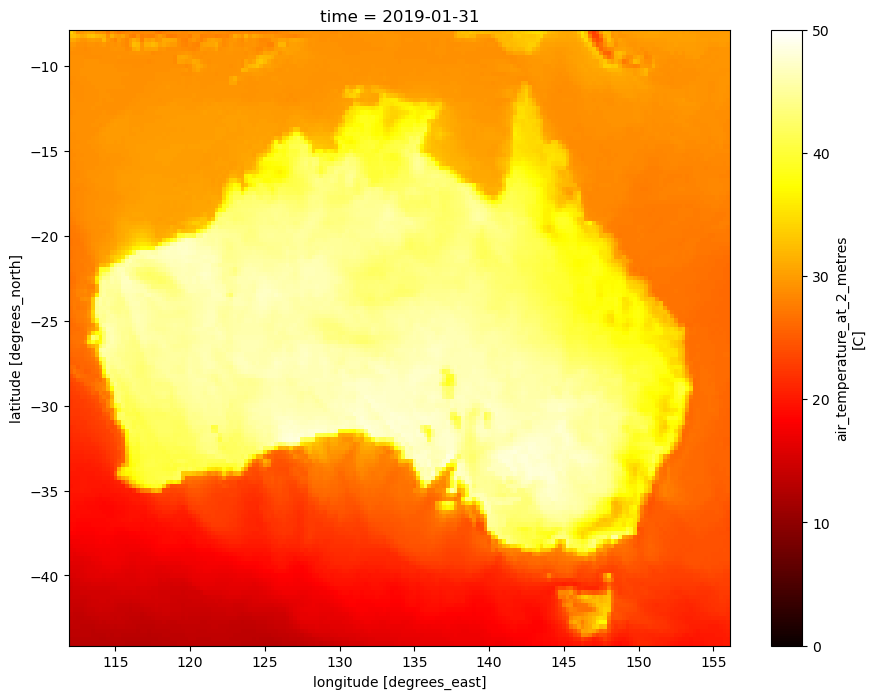

In [15]:
# Plot for each month
temp_max_month[temp_var].plot(vmin=0, vmax=50, cmap ='hot', size=8);

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** February 2023

**Compatible datacube version:** 

In [16]:
print(datacube.__version__)

1.8.11


## Tags
<!-- Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html) -->